In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

GPU Type: Tesla T4

ARCH Value: -gencode arch=compute_75,code=[sm_75,compute_75]


In [ ]:
!nvidia-smi

Sat Oct 15 21:55:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
import cv2
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print("Dataset Train :")
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/Dataset_split/train'))
print("Dataset Validasi")
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/Dataset_split/test'))

Dataset Train :
['Pa Tangke Lumu', 'Pa Lulun Pao', 'Pa Tumuru', 'Pa Somba']
Dataset Validasi
['Pa Tangke Lumu', 'Pa Lulun Pao', 'Pa Tumuru', 'Pa Somba']


In [ ]:
train_directory = "/content/drive/MyDrive/Colab Notebooks/Dataset_split/train"
valid_directory = "/content/drive/MyDrive/Colab Notebooks/Dataset_split/test"

#1

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 100
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  0.0001


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/100
50/50 [==============================] - 19s 304ms/step - loss: 1.0616 - accuracy: 0.5500 - val_loss: 1.2866 - val_accuracy: 0.3151
Epoch 2/100
50/50 [==============================] - 13s 256ms/step - loss: 0.6995 - accuracy: 0.7550 - val_loss: 1.2696 - val_accuracy: 0.2656
Epoch 3/100
50/50 [==============================] - 13s 254ms/step - loss: 0.5181 - accuracy: 0.8425 - val_loss: 1.2859 - val_accuracy: 0.2708
Epoch 4/100
50/50 [==============================] - 13s 257ms/step - loss: 0.4055 - accuracy: 0.8681 - val_loss: 1.1802 - val_accuracy: 0.3203
Epoch 5/100
50/50 [==============================] - 13s 261ms/step - loss: 0.3323 - accuracy: 0.8944 - val_loss: 1.0684 - val_accuracy: 0.4089
Epoch 6/100
50/50 [==============================] - 13s 261ms/step - loss: 0.2708 - accuracy: 0.9206 - val_loss: 0.7168 - val_accuracy: 0.6510
Epoch 7/100
50/50 [==============================] - 13s 261ms/step - loss: 0.2691 - accuracy: 0.9087 - val_loss: 0.7275 - val_accuracy:

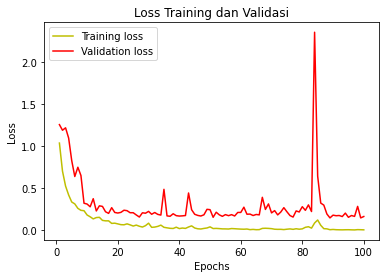

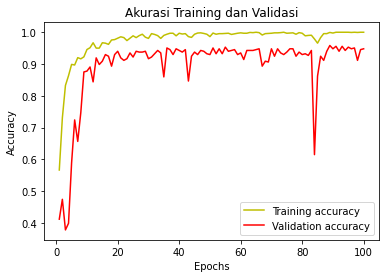

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model100.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights100.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model100.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model100.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 31ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Report Testing :
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       1.00      0.86      0.92         7
           2       1.00      1.00      1.00        10
           3       0.86      1.00      0.92         6

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.93        32
weighted avg       0.94      0.94      0.94        32



#2

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 100
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 0.00001
# if epochs > 180:
#     lr *= 0.5e-3
# elif epochs > 160:
#     lr *= 1e-3
# elif epochs > 120:
#     lr *= 1e-2
# elif epochs > 80:
#     lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  1e-05


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/100
50/50 [==============================] - 18s 272ms/step - loss: 1.3212 - accuracy: 0.3750 - val_loss: 1.3737 - val_accuracy: 0.3802
Epoch 2/100
50/50 [==============================] - 13s 255ms/step - loss: 1.1536 - accuracy: 0.5138 - val_loss: 1.3310 - val_accuracy: 0.4740
Epoch 3/100
50/50 [==============================] - 13s 270ms/step - loss: 1.0641 - accuracy: 0.5631 - val_loss: 1.2734 - val_accuracy: 0.4297
Epoch 4/100
50/50 [==============================] - 13s 254ms/step - loss: 1.0007 - accuracy: 0.5962 - val_loss: 1.2041 - val_accuracy: 0.4974
Epoch 5/100
50/50 [==============================] - 13s 252ms/step - loss: 0.9392 - accuracy: 0.6494 - val_loss: 1.1005 - val_accuracy: 0.6432
Epoch 6/100
50/50 [==============================] - 13s 254ms/step - loss: 0.8848 - accuracy: 0.6938 - val_loss: 1.0038 - val_accuracy: 0.6771
Epoch 7/100
50/50 [==============================] - 13s 254ms/step - loss: 0.8349 - accuracy: 0.7150 - val_loss: 0.9094 - val_accuracy:

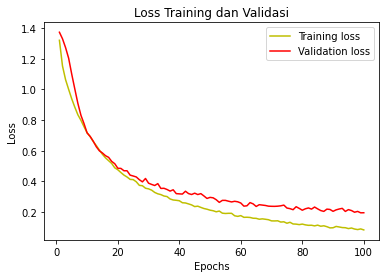

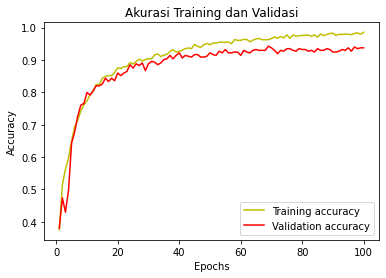

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model200.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights200.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model200.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model200.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 97ms/step
Report Testing :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



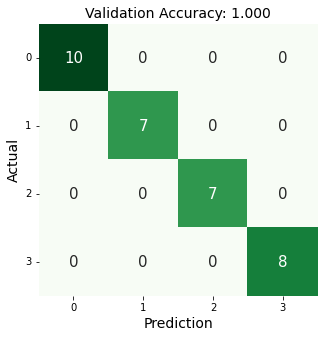

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#2.1

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 200
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 0.00001
# if epochs > 180:
#     lr *= 0.5e-3
# elif epochs > 160:
#     lr *= 1e-3
# elif epochs > 120:
#     lr *= 1e-2
# elif epochs > 80:
#     lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  1e-05


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/200
50/50 [==============================] - 18s 294ms/step - loss: 1.3461 - accuracy: 0.3594 - val_loss: 1.4300 - val_accuracy: 0.3177
Epoch 2/200
50/50 [==============================] - 13s 252ms/step - loss: 1.1692 - accuracy: 0.5056 - val_loss: 1.3899 - val_accuracy: 0.4427
Epoch 3/200
50/50 [==============================] - 13s 252ms/step - loss: 1.0824 - accuracy: 0.5556 - val_loss: 1.3271 - val_accuracy: 0.5104
Epoch 4/200
50/50 [==============================] - 13s 255ms/step - loss: 1.0067 - accuracy: 0.5950 - val_loss: 1.2401 - val_accuracy: 0.5182
Epoch 5/200
50/50 [==============================] - 13s 251ms/step - loss: 0.9445 - accuracy: 0.6550 - val_loss: 1.1364 - val_accuracy: 0.5964
Epoch 6/200
50/50 [==============================] - 13s 255ms/step - loss: 0.8902 - accuracy: 0.6875 - val_loss: 1.0152 - val_accuracy: 0.6562
Epoch 7/200
50/50 [==============================] - 13s 254ms/step - loss: 0.8467 - accuracy: 0.7131 - val_loss: 0.9242 - val_accuracy:

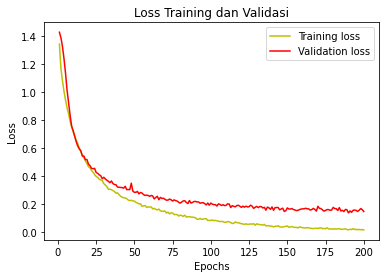

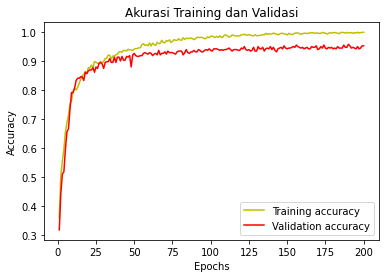

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model1200.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights1200.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model1200.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model1200.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 32ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        11

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Report Testing :
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.80      1.00      0.89         4

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



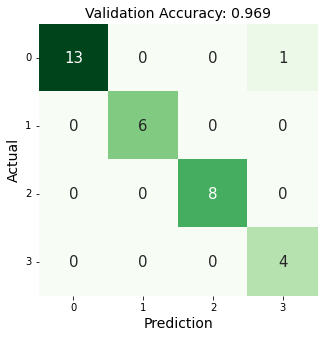

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#2.2

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 300
batch_size = 16
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 0.00001
# if epochs > 180:
#     lr *= 0.5e-3
# elif epochs > 160:
#     lr *= 1e-3
# elif epochs > 120:
#     lr *= 1e-2
# elif epochs > 80:
#     lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  1e-05


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/300
100/100 [==============================] - 18s 143ms/step - loss: 1.2615 - accuracy: 0.4150 - val_loss: 1.3285 - val_accuracy: 0.4325
Epoch 2/300
100/100 [==============================] - 13s 134ms/step - loss: 1.0975 - accuracy: 0.5450 - val_loss: 1.2224 - val_accuracy: 0.5075
Epoch 3/300
100/100 [==============================] - 14s 143ms/step - loss: 0.9993 - accuracy: 0.6256 - val_loss: 1.0637 - val_accuracy: 0.6200
Epoch 4/300
100/100 [==============================] - 13s 134ms/step - loss: 0.9107 - accuracy: 0.6681 - val_loss: 0.8972 - val_accuracy: 0.7275
Epoch 5/300
100/100 [==============================] - 13s 133ms/step - loss: 0.8444 - accuracy: 0.7094 - val_loss: 0.8054 - val_accuracy: 0.7775
Epoch 6/300
100/100 [==============================] - 14s 139ms/step - loss: 0.7868 - accuracy: 0.7350 - val_loss: 0.7408 - val_accuracy: 0.7775
Epoch 7/300
100/100 [==============================] - 13s 134ms/step - loss: 0.7368 - accuracy: 0.7713 - val_loss: 0.6825 -

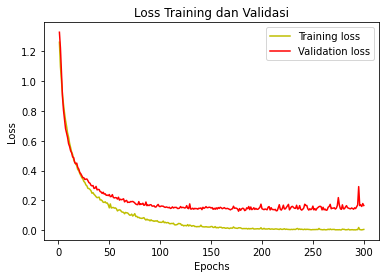

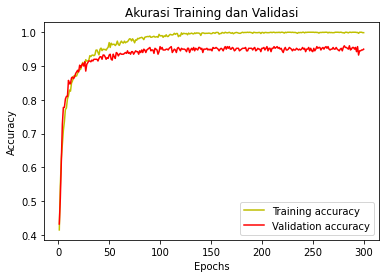

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model2200.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights2200.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model2200.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model2200.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 26ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Report Testing :
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       0.67      1.00      0.80         2

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.84        16
weighted avg       0.91      0.88      0.86        16



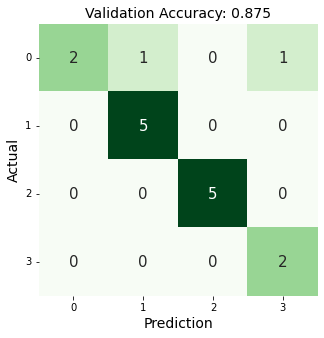

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#2.3

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 400
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 0.000001
# if epochs > 180:
#     lr *= 0.5e-3
# elif epochs > 160:
#     lr *= 1e-3
# elif epochs > 120:
#     lr *= 1e-2
# elif epochs > 80:
#     lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  1e-06


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/400
50/50 [==============================] - 17s 277ms/step - loss: 1.3544 - accuracy: 0.3094 - val_loss: 1.3681 - val_accuracy: 0.3255
Epoch 2/400
50/50 [==============================] - 13s 259ms/step - loss: 1.3184 - accuracy: 0.3781 - val_loss: 1.3515 - val_accuracy: 0.3750
Epoch 3/400
50/50 [==============================] - 13s 258ms/step - loss: 1.2924 - accuracy: 0.4069 - val_loss: 1.3350 - val_accuracy: 0.4115
Epoch 4/400
50/50 [==============================] - 13s 256ms/step - loss: 1.2716 - accuracy: 0.4194 - val_loss: 1.3138 - val_accuracy: 0.4323
Epoch 5/400
50/50 [==============================] - 13s 255ms/step - loss: 1.2547 - accuracy: 0.4444 - val_loss: 1.2872 - val_accuracy: 0.4974
Epoch 6/400
50/50 [==============================] - 14s 284ms/step - loss: 1.2395 - accuracy: 0.4569 - val_loss: 1.2652 - val_accuracy: 0.4714
Epoch 7/400
50/50 [==============================] - 13s 255ms/step - loss: 1.2276 - accuracy: 0.4600 - val_loss: 1.2389 - val_accuracy:

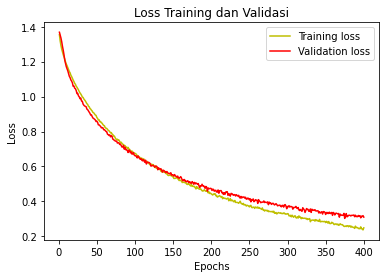

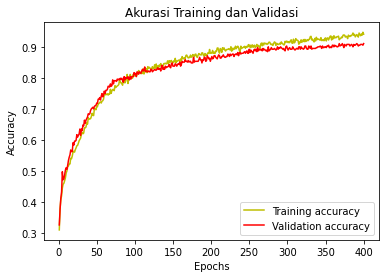

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model3200.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights3200.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model3200.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model3200.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 35ms/step
Report Training :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         9
           3       1.00      0.90      0.95        10

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.96        32
weighted avg       0.97      0.97      0.97        32

Report Testing :
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00        11
           3       0.86      1.00      0.92         6

    accuracy                           0.94        32
   macro avg       0.93      0.94      0.93        32
weighted avg       0.95      0.94      0.94        32



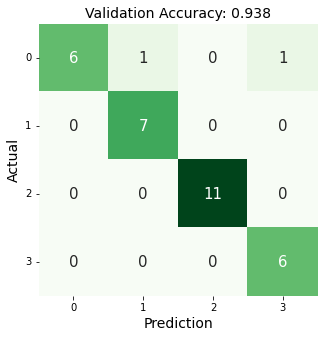

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#3

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 100
batch_size = 8
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  0.0001


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/100
200/200 [==============================] - 19s 79ms/step - loss: 0.9855 - accuracy: 0.5788 - val_loss: 1.1768 - val_accuracy: 0.3725
Epoch 2/100
200/200 [==============================] - 16s 79ms/step - loss: 0.6298 - accuracy: 0.7606 - val_loss: 0.6142 - val_accuracy: 0.7475
Epoch 3/100
200/200 [==============================] - 14s 72ms/step - loss: 0.5073 - accuracy: 0.8150 - val_loss: 0.4744 - val_accuracy: 0.8250
Epoch 4/100
200/200 [==============================] - 15s 72ms/step - loss: 0.3995 - accuracy: 0.8500 - val_loss: 0.4153 - val_accuracy: 0.8500
Epoch 5/100
200/200 [==============================] - 15s 73ms/step - loss: 0.3515 - accuracy: 0.8712 - val_loss: 0.3162 - val_accuracy: 0.8875
Epoch 6/100
200/200 [==============================] - 15s 73ms/step - loss: 0.3117 - accuracy: 0.8856 - val_loss: 0.3346 - val_accuracy: 0.8875
Epoch 7/100
200/200 [==============================] - 14s 72ms/step - loss: 0.2683 - accuracy: 0.9025 - val_loss: 0.7057 - val_ac

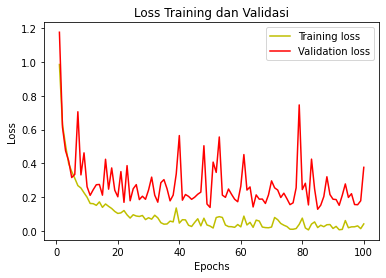

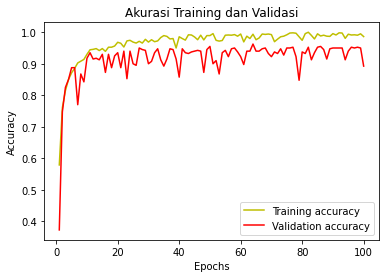

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model300.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights300.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model300.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model300.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 22ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Report Testing :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



#4

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 100
batch_size = 4
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 5e-07
# if epochs > 180:
#     lr *= 0.5e-3
# elif epochs > 160:
#     lr *= 1e-3
# elif epochs > 120:
#     lr *= 1e-2
# elif epochs > 80:
#     lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  5e-07


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/100
400/400 [==============================] - 22s 43ms/step - loss: 1.4757 - accuracy: 0.2906 - val_loss: 1.3987 - val_accuracy: 0.3375
Epoch 2/100
400/400 [==============================] - 16s 39ms/step - loss: 1.3552 - accuracy: 0.3481 - val_loss: 1.2902 - val_accuracy: 0.3575
Epoch 3/100
400/400 [==============================] - 17s 42ms/step - loss: 1.3070 - accuracy: 0.3850 - val_loss: 1.2485 - val_accuracy: 0.4500
Epoch 4/100
400/400 [==============================] - 16s 39ms/step - loss: 1.2879 - accuracy: 0.4444 - val_loss: 1.2169 - val_accuracy: 0.5150
Epoch 5/100
400/400 [==============================] - 18s 45ms/step - loss: 1.2591 - accuracy: 0.4794 - val_loss: 1.1954 - val_accuracy: 0.5150
Epoch 6/100
400/400 [==============================] - 16s 39ms/step - loss: 1.2408 - accuracy: 0.4806 - val_loss: 1.1738 - val_accuracy: 0.5275
Epoch 7/100
400/400 [==============================] - 16s 39ms/step - loss: 1.2199 - accuracy: 0.5194 - val_loss: 1.1554 - val_ac

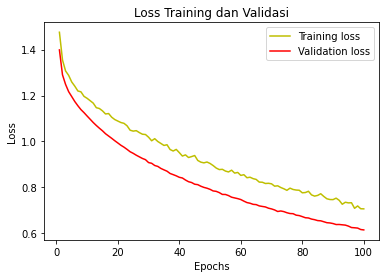

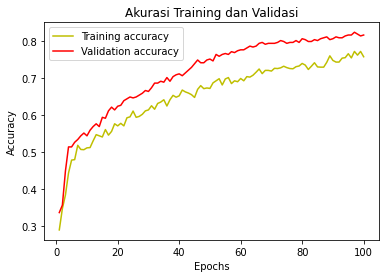

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model400.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights400.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model400.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model400.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 22ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Report Testing :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



#5

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 500
batch_size = 8
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  5e-07


Normalisasi

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

102981632/102967424 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/500
200/200 [==============================] - 1396s 7s/step - loss: 1.5151 - accuracy: 0.2037 - val_loss: 1.4943 - val_accuracy: 0.2475
Epoch 2/500
200/200 [==============================] - 15s 77ms/step - loss: 1.3918 - accuracy: 0.2950 - val_loss: 1.3644 - val_accuracy: 0.3525
Epoch 3/500
200/200 [==============================] - 15s 77ms/step - loss: 1.3268 - accuracy: 0.4131 - val_loss: 1.2954 - val_accuracy: 0.4475
Epoch 4/500
200/200 [==============================] - 15s 77ms/step - loss: 1.2923 - accuracy: 0.4431 - val_loss: 1.2634 - val_accuracy: 0.4775
Epoch 5/500
200/200 [==============================] - 16s 77ms/step - loss: 1.2748 - accuracy: 0.4406 - val_loss: 1.2411 - val_accuracy: 0.4800
Epoch 6/500
200/200 [==============================] - 16s 82ms/step - loss: 1.2549 - accuracy: 0.4613 - val_loss: 1.2225 - val_accuracy: 0.4900
Epoch 7/500
200/200 [==============================] - 15s 77ms/step - loss: 1.2352 - accuracy: 0.4650 - val_loss: 1.2056 - val_ac

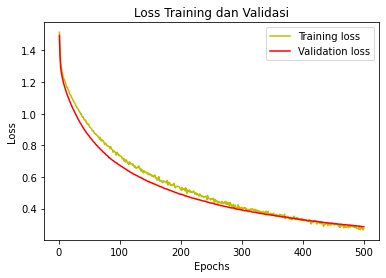

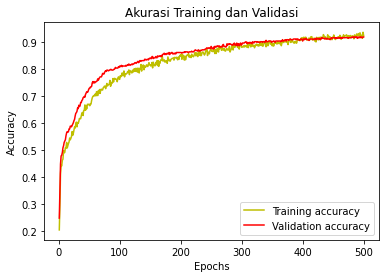

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model500.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights500.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model500.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model500.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Report Testing :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

